In [1]:
# Necessary outsource packages for this jupyter notebook

!pip install missingno
!pip install pyampute
!pip install hiclass"[xai]"
!pip install optuna
!pip install plotly
!pip install lightgbm
!pip install hierarchical_confusion_matrix

  Using cached missingno-0.5.2-py3-none-any.whl.metadata (639 bytes)
Using cached missingno-0.5.2-py3-none-any.whl (8.7 kB)

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip
  Using cached pyampute-0.0.3-py3-none-any.whl.metadata (1.3 kB)
Using cached pyampute-0.0.3-py3-none-any.whl (20 kB)

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip
  Using cached hiclass-4.11.0-py3-none-any.whl.metadata (17 kB)
  Using cached scipy-1.12.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
  Using cached shap-0.44.1-cp311-cp311-manylinux_2_12_x86_64.manylinux2010_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (24 kB)
  Using cached xarray-2023.1.0-py3-none-any.whl.metadata (6.2 kB)
  Using cached slicer-0.0.7-py3-none-any.whl.metadata (3.7 kB)
Using cached shap-0.44.1-cp311-cp311-manylinux_2_12_x86_64.manylinux2010_x86_64.manylinux_2_1

In [2]:
# Import necessary packages
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
import pandas as pd
import numpy as np
import random
import optuna
import time
import networkx as nx

from pyampute.exploration.mcar_statistical_tests import MCARTest
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from hiclass import LocalClassifierPerNode, FlatClassifier
from hiclass.metrics import f1
from lightgbm import LGBMClassifier
from lightgbm import early_stopping
from hierarchical_confusion_matrix import determineHierarchicalConfusionMatrix, printHierarchicalConfusionMatrix

# 1 Get the data

In [3]:
# Read in data
raw_data = pd.read_csv("ALL.csv", low_memory=False)

# Keep useful cols
columns_keep = ["tic",     # ticker
                "gsubind", # GICS code
                "fyear",   # fiscal year
                "at",      # total assets
                "che",     # cash and short-term investments
                "rect",    # receivables
                "invt",    # inventory
                "act",     # current assets
                "ppent",   # property, plant and equipment (net)
                "ivaeq",   # investment and advances
                "intan",   # intangible assets
                "ap",      # accounts payable
                "dlc",     # debt in current laibilities
                "ui",      # unearned income
                "lct",     # current liabilities
                "dltt",    # long-term debt
                "lt",      # total liabilities
                "pstk",    # preferred stock
                "ceq",     # common equity
                "sale",    # sales/turnover
                "cogs",    # cost of goods sold
                "xrd",     # research and development expense
                "ib"]      # income before extraordinary items

raw_data = raw_data[columns_keep]

# Check the size and type of data
raw_shape1 = raw_data.shape
print(f"The size of raw_data is {raw_shape1}.")

raw_data.info()

The size of raw_data is (128646, 23).
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128646 entries, 0 to 128645
Data columns (total 23 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   tic      128593 non-null  object 
 1   gsubind  94459 non-null   float64
 2   fyear    128417 non-null  float64
 3   at       93228 non-null   float64
 4   che      82427 non-null   float64
 5   rect     81414 non-null   float64
 6   invt     84616 non-null   float64
 7   act      69234 non-null   float64
 8   ppent    90570 non-null   float64
 9   ivaeq    88123 non-null   float64
 10  intan    92048 non-null   float64
 11  ap       86374 non-null   float64
 12  dlc      92560 non-null   float64
 13  ui       3590 non-null    float64
 14  lct      69337 non-null   float64
 15  dltt     92990 non-null   float64
 16  lt       93119 non-null   float64
 17  pstk     92883 non-null   float64
 18  ceq      93011 non-null   float64
 19  sale     82060 non-null   f

In [4]:
# Check fiscal year
raw_data["fyear"].unique()

array([2013., 2014., 2015., 2016., 2017., 2018., 2019., 2020., 2021.,
       2022., 2023.,   nan])

### Preprocessing

In [5]:
gics_codes = [
    "10101010", "10101020", 
    "10102010", "10102020", "10102030", "10102040", "10102050",
    "15101010", "15101020", "15101030", "15101040", "15101050", 
    "15102010", 
    "15103010", "15103020",
    "15104010", "15104020", "15104025", "15104030", "15104040", "15104045", "15104050", 
    "15105010", "15105020", 
    "20101010", 
    "20102010", "20103010", 
    "20104010", "20104020", 
    "20105010", 
    "20106010", "20106015", "20106020", 
    "20107010", 
    "20201010", "20201050","20201060", "20201070", "20201080", 
    "20202010", "20202020", "20202030", 
    "20301010", 
    "20302010",
    "20303010", 
    "20304010", "20304030", "20304040",
    "20305010", "20305020", "20305030",
    "25101010", "25102010", 
    "25102020", "25102020",
    "25201010", "25201020", "25201030", "25201040", "25201050",
    "25202010", 
    "25203010", "25203020", "25203030", 
    "25301010", "25301020", "25301030", "25301040",
    "25302010", "25302020", 
    "25501010",
    "25503030",
    "25504010", "25504020", "25504030", "25504040", "25504050", "25504060",
    "30101010", "30101020", "30101030", "30101040", 
    "30201010", "30201020", "30201030", 
    "30202010", "30202030", 
    "30203010",
    "30301010", 
    "30302010", 
    "35101010", "35101020", 
    "35102010", "35102015", "35102020", "35102030", 
    "35103010", 
    "35201010", 
    "35202010", 
    "35203010",
    "40101010", "40101015", 
    "40201020", "40201030", 
    "40201040", "40201050", "40201060", 
    "40202010",
    "40203010", "40203020", "40203030", "40203040",
    "40204010", 
    "40301010", "40301020", "40301030", "40301040", "40301050",
    "45102010", "45102030",
    "45103010", "45103020", 
    "45201020", 
    "45202030", 
    "45203010", "45203015", "45203020", "45203030",
    "45301010", "45301020", 
    "50101010", "50101020", 
    "50102010",
    "50201010", "50201020", "50201030", "50201040", 
    "50202010", "50202020", 
    "50203010",
    "55101010", 
    "55102010", 
    "55103010", 
    "55104010", 
    "55105010", "55105020", 
    "60101010", 
    "60102510", 
    "60103010", 
    "60104010",
    "60105010", 
    "60106010", "60106020", 
    "60107010",
    "60108010", "60108020", "60108030", "60108040", "60108050", 
    "60201010", "60201020", "60201030", "60201040"
]
len(gics_codes)

163

In [6]:
# Preprocess the target attributes
def process_labels(dataset):
    dataset = dataset.dropna(subset=["gsubind"])                # drop rows without GICS codes
    dataset = dataset.reset_index(drop=True)                    # reset index

    dataset["GICS"] = dataset["gsubind"].apply(int).apply(str)  # convert data type into strings and assign new colname
    dataset.drop(columns=["gsubind"], inplace=True)             # drop original target attribute      
    dataset.reset_index(drop=True, inplace=True)                # reset index

    dataset = dataset[dataset["GICS"].isin(gics_codes)]         # delete obs. whose GICS not in "gics_code"

    return dataset

# Run function
raw_data_clean_label = process_labels(raw_data)

# Check data shape
raw_shape2 = raw_data_clean_label.shape
print(f"{raw_shape1[0] - raw_shape2[0]} rows are dropped because of no labels.")
print(f"The size of raw_data is {raw_shape2}.")

36261 rows are dropped because of no labels.
The size of raw_data is (92385, 23).


In [7]:
# Drop duplicated observations
def drop_duplicates(dataset):
    # Create an empty list to store result
    cleaned_dataframes = [] 

    # For loop to clean duplicated obs. by year
    for year in dataset["fyear"].unique():

        data = dataset[dataset["fyear"] == year]                                         # filter data for the current year
        duplicates = data[data.duplicated("tic", keep=False)].sort_values("tic")         # find duplicates based on the 'tic' column

        def which_to_drop(company):
            return company.isnull().sum(axis=1).idxmax()                                 # find the index of the row with the fewest missing values
        indices_to_drop = duplicates.groupby("tic").apply(which_to_drop).values.tolist() # apply the which_to_keep function to each group of duplicates
        data_cleaned = data.drop(index=indices_to_drop)                                  # drop the duplicates, keeping only the selected indices
        cleaned_dataframes.append(data_cleaned)                                          # append the cleaned data to the list
    # For loop ends

    # Concatenate all cleaned dataframes into a single dataframe
    cleaned_dataset = pd.concat(cleaned_dataframes)

    return cleaned_dataset

# Run function
raw_data_drop_dup1 = drop_duplicates(raw_data_clean_label)

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
DataFrameGroupBy.apply operated on the grou

##### Missing "tic"

In [8]:
# Check obs. with "tic" missing
raw_data_drop_dup1[raw_data_drop_dup1["tic"].isna()]

,tic,fyear,at,che,rect,invt,act,ppent,ivaeq,intan,...,lct,dltt,lt,pstk,ceq,sale,cogs,xrd,ib,GICS
13795,NaN,2014.0,31.713,2.174,NaN,0.000,3.345,9.046,18.422,0.000,...,5.582,0.000,6.425,0.0,23.693,3.919,8.130,NaN,-5.541,40203010
67372,NaN,2014.0,88204.000,8127.000,41219.000,0.000,NaN,124.000,93.000,62.000,...,NaN,239.000,83204.000,350.0,4450.000,2795.000,781.000,NaN,639.000,40101010
67373,NaN,2014.0,88204.000,NaN,NaN,NaN,NaN,124.000,93.000,62.000,...,NaN,239.000,83204.000,350.0,4450.000,NaN,NaN,NaN,639.000,40101010
13796,NaN,2015.0,31.103,3.993,NaN,0.000,5.050,5.752,19.679,0.000,...,5.211,0.000,6.285,0.0,24.467,2.610,4.200,NaN,-1.512,40203010
67374,NaN,2015.0,94024.000,8345.000,48378.000,0.000,NaN,110.000,60.000,61.000,...,NaN,239.000,88648.000,850.0,4526.000,2594.000,791.000,NaN,442.000,40101010
67375,NaN,2015.0,94024.000,NaN,NaN,NaN,NaN,110.000,60.000,61.000,...,NaN,239.000,88648.000,850.0,4526.000,NaN,NaN,NaN,442.000,40101010
13797,NaN,2016.0,29.187,3.590,NaN,0.000,10.318,0.000,18.263,0.000,...,6.053,0.000,6.053,0.0,23.052,0.000,0.000,NaN,-1.193,40203010
67376,NaN,2016.0,94657.000,7133.000,46907.000,0.000,NaN,104.000,46.000,70.000,...,NaN,1039.000,89242.000,850.0,4565.000,2694.000,724.000,NaN,524.000,40101010
67377,NaN,2016.0,94657.000,NaN,NaN,NaN,NaN,104.000,46.000,70.000,...,NaN,1039.000,89242.000,850.0,4565.000,NaN,NaN,NaN,524.000,40101010
13798,NaN,2017.0,23.453,1.642,NaN,0.000,3.268,0.000,19.562,0.000,...,0.633,0.000,0.633,0.0,22.820,0.100,1.057,NaN,-1.826,40203010


In [9]:
# Drop duplicates manually
index_drop_dup = [67223, 67225, 67227, 67229, 67231, 67233, 67235, 67237, 67239, 67241]
raw_data_drop_dup2 = raw_data_drop_dup1.drop(index=index_drop_dup)

raw_data_drop_useless = raw_data_drop_dup2.drop(columns=["tic", "fyear"])

# Check data shape
raw_shape3 =  raw_data_drop_useless.shape
print(f"{raw_shape2[0] - raw_shape3[0]} duplicated obs. are dropped.")
print(f"The size of raw_data is {raw_shape3}.")

10537 duplicated obs. are dropped.
The size of raw_data is (81848, 21).


##### Total assets
"at" is the total assets. \
Since we need to use common size based on it, "at" must be available and positive.

In [10]:
# Clean observations whose total assets are missing or <=0
def clean_at(dataset):
    
    dataset.dropna(subset=["at"], inplace=True)                           # drop rows without "at"
    dataset.drop(index = dataset[dataset["at"] <= 0].index, inplace=True) # Drop rows with "at" < 0
    dataset.reset_index(drop=True, inplace=True)                          # reset index

    return dataset

# Run function
raw_data_clean_at = clean_at(raw_data_drop_useless)

# Check data shape
raw_shape4 =  raw_data_clean_at.shape
print(f"{raw_shape3[0] - raw_shape4[0]} obs. are dropped because of cleaning at.")
print(f"The size of raw_data is {raw_shape4}.")

2463 obs. are dropped because of cleaning at.
The size of raw_data is (79385, 21).


In [11]:
# Filter out balance sheet items >= total assets
def clean_balance_sheet_at(dataset):
    
    index1 = set()                                             # create a set to store index values

    # For loop to find index with at least on item is >= total asset
    for col in dataset.columns[1:16]:
        indices = dataset[dataset[col] >= dataset["at"]].index # return index
        index1.update(indices)                                 # update index
    # For loop ends

    dataset.drop(index=index1, inplace=True)                   # drop rows with selected index
    dataset.reset_index(drop=True, inplace=True)               # reset index

    return dataset

# Run function
raw_data_clean_bs = clean_balance_sheet_at(raw_data_clean_at)

# Check data shape
raw_shape5 =  raw_data_clean_bs.shape
print(f"{raw_shape4[0] - raw_shape5[0]} obs. are dropped because of balance sheet items >= at.")
print(f"The size of raw_data is {raw_shape5}.")

10984 obs. are dropped because of balance sheet items >= at.
The size of raw_data is (68401, 21).


In [12]:
# Filter out balance sheet items < 0
def clean_balance_sheet_0(dataset):
    
    index2 = set()                               # create a set to store index values

    # For loop to find index with at least on item is < 0
    for col in dataset.columns[1:16]:
        indices = dataset[dataset[col] <0].index # return index
        index2.update(indices)                   # update index
    # For loop ends

    dataset.drop(index=index2, inplace=True)     # drop rows with selected index
    dataset.reset_index(drop=True, inplace=True) # reset index

    return dataset

# Run function
raw_data_clean_bs0 = clean_balance_sheet_0(raw_data_clean_bs)

# Check data shape
raw_shape6 =  raw_data_clean_bs0.shape
print(f"{raw_shape5[0] - raw_shape6[0]} obs. are dropped because of balance sheet items < 0.")
print(f"The size of raw_data is {raw_shape6}.")

795 obs. are dropped because of balance sheet items < 0.
The size of raw_data is (67606, 21).


In [13]:
# Filter out rows with sales <= 0
def clean_sale(dataset):
    
    dataset.dropna(subset=["sale"], inplace=True)                           # drop rows without "sale"
    dataset.drop(index = dataset[dataset["sale"] <= 0].index, inplace=True) # drop rows with "sale" <=0
    dataset.reset_index(drop=True, inplace=True)                            # reset index

    return dataset

# Run function
raw_data_clean_sale = clean_sale(raw_data_clean_bs0)

# Check data shape
raw_shape7 =  raw_data_clean_sale.shape
print(f"{raw_shape6[0] - raw_shape7[0]} obs. are dropped because of cleaning sales.")
print(f"The size of raw_data is {raw_shape7}.")

7348 obs. are dropped because of cleaning sales.
The size of raw_data is (60258, 21).


In [14]:
def clean_invt(dataset):
    
    dataset.dropna(subset=["invt"], inplace=True)                           # drop rows without "invt"
    dataset.drop(index = dataset[dataset["invt"] <= 0].index, inplace=True) # Drop rows with "invt" <=0
    dataset.reset_index(drop=True, inplace=True)                            # reset index

    return dataset

# Run function
raw_data_clean_invt = clean_invt(raw_data_clean_sale)

# Check data shape
raw_shape8 =  raw_data_clean_sale.shape
print(f"{raw_shape7[0] - raw_shape8[0]} obs. are dropped because of cleaning ivnt.")
print(f"The size of raw_data is {raw_shape8}.")

19402 obs. are dropped because of cleaning ivnt.
The size of raw_data is (40856, 21).


In [15]:
# Assign new object to cleaned data
raw_data_final = raw_data_clean_invt

### Sample a test set

In [16]:
# Train test split
train_X, test_X, train_y, test_y = train_test_split(raw_data_final.drop(columns=["GICS"]), # features
                                                    raw_data_final["GICS"],                # label
                                                    test_size=0.3,                         # test size
                                                    random_state=42,                       # for reproducibility
                                                    shuffle=True,                          # shuffle the data for randomness
                                                    stratify=raw_data_final["GICS"])

train_data = pd.concat([train_X, train_y], axis=1)  # combine features and label

# 2 Explore the data

In [17]:
# Create a copy of data for exploration
explore_df = train_data.copy(deep=True)

### Characteristics of each attribute

In [18]:
# Feature names
explore_df.columns

Index(['at', 'che', 'rect', 'invt', 'act', 'ppent', 'ivaeq', 'intan', 'ap',
       'dlc', 'ui', 'lct', 'dltt', 'lt', 'pstk', 'ceq', 'sale', 'cogs', 'xrd',
       'ib', 'GICS'],
      dtype='object')

In [19]:
# Type
explore_df.dtypes

at       float64
che      float64
rect     float64
invt     float64
act      float64
ppent    float64
ivaeq    float64
intan    float64
ap       float64
dlc      float64
ui       float64
lct      float64
dltt     float64
lt       float64
pstk     float64
ceq      float64
sale     float64
cogs     float64
xrd      float64
ib       float64
GICS      object
dtype: object

In [20]:
# Statistical summary
explore_df.describe()

,at,che,rect,invt,act,ppent,ivaeq,intan,ap,dlc,ui,lct,dltt,lt,pstk,ceq,sale,cogs,xrd,ib
count,2.859900e+04,2.859700e+04,2.849300e+04,28599.000000,24157.000000,28516.000000,26440.000000,28258.000000,2.852500e+04,28595.000000,0.0,24151.000000,28525.000000,2.856700e+04,28527.000000,28549.000000,28599.000000,28599.000000,13930.000000,28599.000000
mean,2.005510e+04,2.677269e+03,5.895662e+03,1165.418104,2740.948055,3517.045365,338.583559,2014.389949,6.987654e+03,1463.272468,NaN,2177.298164,3461.116324,1.570999e+04,78.285764,4063.906981,6117.586099,4032.243322,303.662787,446.956584
std,1.318582e+05,2.641614e+04,5.343459e+04,12176.646971,10644.372739,14358.397574,2283.956343,9002.574786,7.311128e+04,14638.226978,NaN,9024.907275,15782.641738,1.197090e+05,955.429317,16573.838362,24547.486448,18269.858759,1724.309805,2616.154410
min,1.500000e-02,0.000000e+00,0.000000e+00,0.001000,0.012000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,NaN,0.008000,0.000000,8.000000e-03,0.000000,0.000000,0.001000,-3703.000000,-0.648000,-22440.000000
25%,2.216260e+02,1.592800e+01,1.596800e+01,5.358000,63.243000,17.560250,0.000000,1.309500,9.448000e+00,1.000000,NaN,27.924500,6.159000,8.430750e+01,0.000000,77.901000,78.032500,31.385000,0.864750,-5.459500
50%,1.245902e+03,8.200000e+01,1.344000e+02,44.148000,327.500000,151.136500,0.000000,50.901500,7.691400e+01,14.985000,NaN,161.760000,145.471000,6.950000e+02,0.000000,391.979000,546.526000,283.087000,12.900000,15.935000
75%,5.966752e+03,3.960000e+02,7.356680e+02,287.950000,1362.900000,1217.775000,3.944250,623.999500,5.710000e+02,150.588000,NaN,868.359500,1330.300000,3.844760e+03,0.000000,1790.400000,2932.962000,1747.900000,78.475000,175.272500
max,3.875393e+06,1.007321e+06,1.297301e+06,530917.000000,264889.386000,292684.091000,47094.000000,310197.000000,2.462303e+06,511853.440000,NaN,227561.873000,349484.000000,3.547515e+06,34838.000000,561273.000000,608481.000000,452776.000000,85622.000000,96995.000000


### Missing values

In [21]:
# % of missing values
def prop_na(dataset):
    global prop_na_col
    prop_na_col = round((dataset.isna().sum() / len(dataset)) * 100, 2).sort_values(ascending=False)
    prop_na = round((dataset.isna().sum().sum() / dataset.size) * 100, 2)

    print(f"Proportion of missing values in each attributes:")
    print(prop_na_col)
    print(f"\n{prop_na}% values are missing in total.\n")

# % of zero values
def prop_0(dataset):
    global prop_0_col
    prop_0_col = round(((dataset == 0).sum() / len(dataset)) * 100, 2).sort_values(ascending=False)
    prop_0 = round(((dataset == 0).sum().sum() / dataset.size) * 100, 2)

    print(f"Proportion of zero values in each attributes:")
    print(prop_0_col)
    print(f"\n{prop_0}% values are zero in total.")

prop_na(explore_df)
prop_0(explore_df)

Proportion of missing values in each attributes:
ui       100.00
xrd       51.29
lct       15.55
act       15.53
ivaeq      7.55
intan      1.19
rect       0.37
ppent      0.29
dltt       0.26
ap         0.26
pstk       0.25
ceq        0.17
lt         0.11
dlc        0.01
che        0.01
ib         0.00
cogs       0.00
at         0.00
sale       0.00
invt       0.00
GICS       0.00
dtype: float64

9.18% values are missing in total.

Proportion of zero values in each attributes:
pstk     89.67
ivaeq    65.08
intan    17.65
dlc      14.14
dltt     11.30
xrd       7.94
che       0.90
rect      0.55
ap        0.40
ppent     0.23
cogs      0.03
at        0.00
ceq       0.00
ib        0.00
sale      0.00
ui        0.00
lt        0.00
lct       0.00
act       0.00
invt      0.00
GICS      0.00
dtype: float64

9.9% values are zero in total.


In [22]:
# Total propotion of na and 0
prop_0na_col = (prop_na_col + prop_0_col).sort_values(ascending=False)
prop_0na_col

ui       100.00
pstk      89.92
ivaeq     72.63
xrd       59.23
intan     18.84
lct       15.55
act       15.53
dlc       14.15
dltt      11.56
rect       0.92
che        0.91
ap         0.66
ppent      0.52
ceq        0.17
lt         0.11
cogs       0.03
ib         0.00
invt       0.00
at         0.00
sale       0.00
GICS       0.00
dtype: float64

p value: 0.0


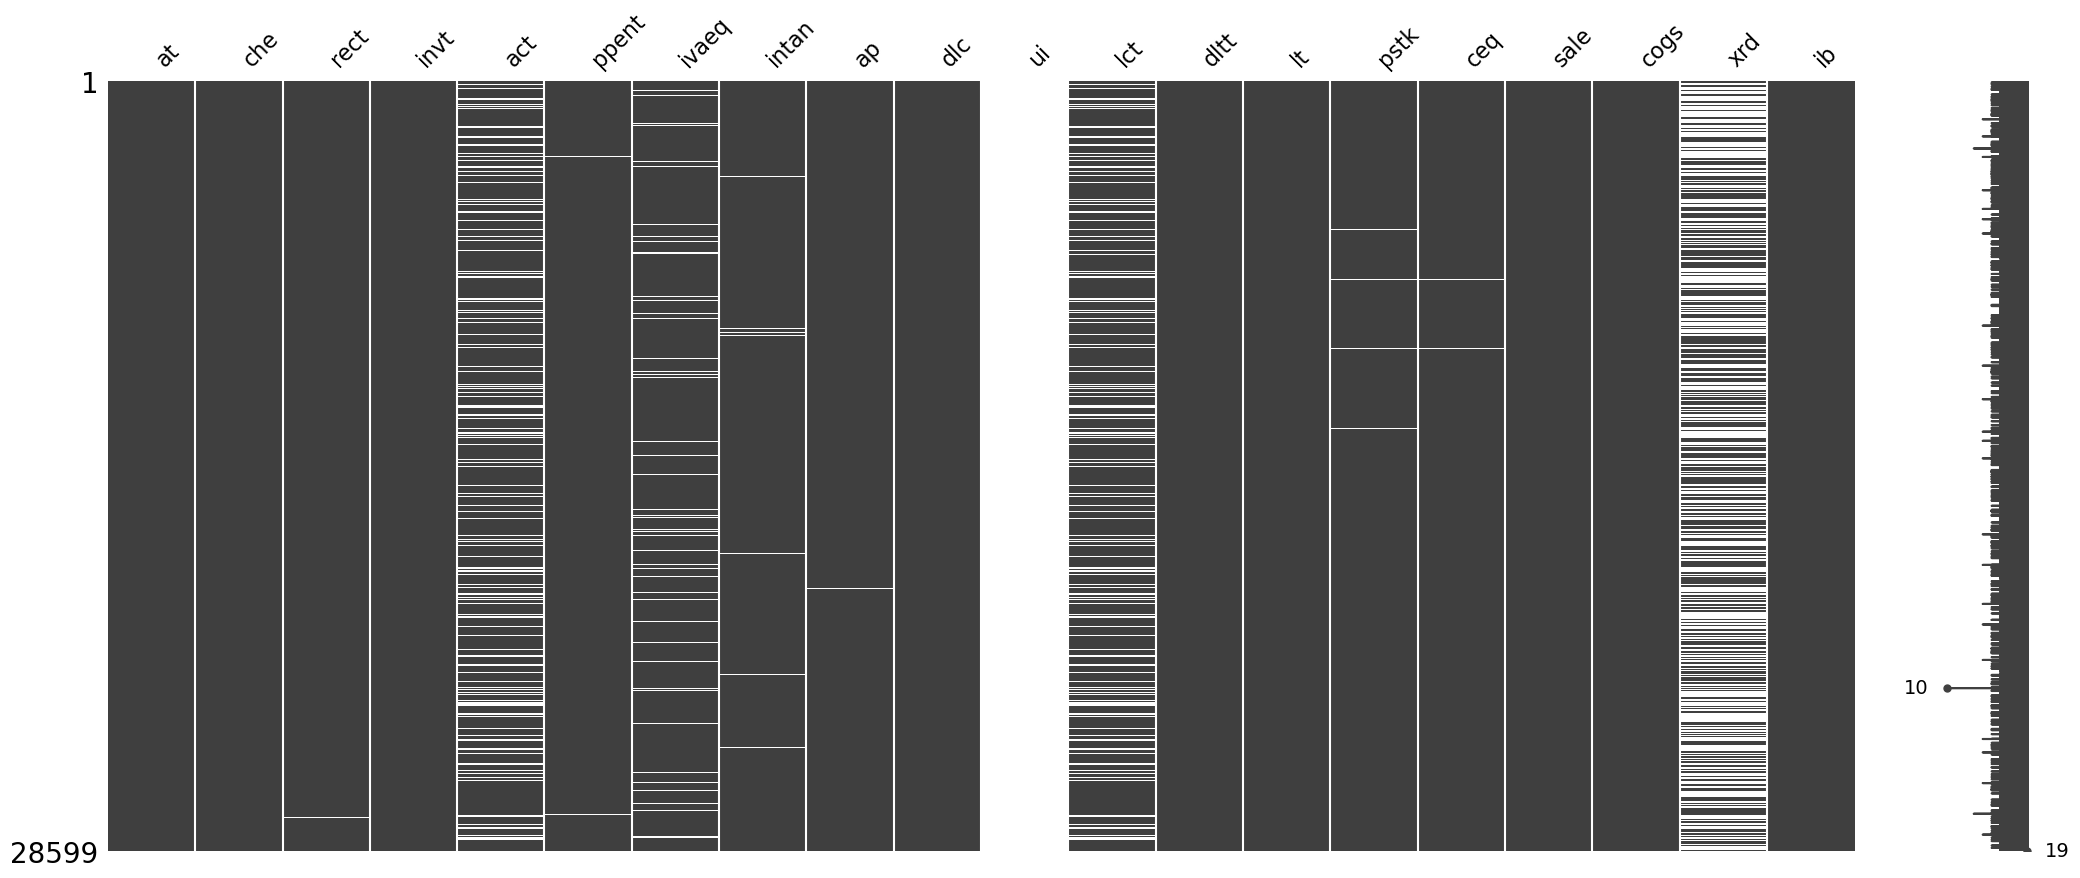

In [23]:
# MCAR test and structure of missing values
def mcar(dataset, image_path=None, export_image=False):
    
    # Little's MCAR test
    missing_data = dataset.isnull()        # extract missing values
    mt = MCARTest(method="little")         # run test
    p_value = mt.little_mcar_test(dataset) # p-value
    print(f"p value: {p_value}")

    # Visualize missingness
    msno.matrix(dataset)
    
    # Export the image
    if export_image:
        plt.savefig(image_path)
    
    plt.show()

# Run function
mcar(explore_df.iloc[:, :-1], image_path="missingness", export_image=False)

This outcome suggests strong evidence against the null hypothesis of Missing Completely at Random (MCAR). \
The sparkline at right summarizes the general shape of the data completeness and points out the rows with the maximum and minimum nullity in the dataset.\
The distribution of missing values by sector.

### Identify the target attributes

In [24]:
# Extract levels of classes
def split_gics(codes):

    # Create empty list to store values
    gics_l1 = []
    gics_l2 = []
    gics_l3 = []
    gics_l4 = []

    # For loop to add values
    for code in codes:
        gics_l1.append(code[:2])  # first 2 digits
        gics_l2.append(code[2:4]) # 3&4 digits
        gics_l3.append(code[4:6]) # 5&6 digits
        gics_l4.append(code[6:8]) # last 2 digits

    # Combine into a data frame
    output = pd.DataFrame({
        "GL1": gics_l1,
        "GL2": gics_l2,
        "GL3": gics_l3,
        "GL4": gics_l4
    })
    
    return output

# Run function
h_gics = split_gics(explore_df["GICS"])

In [25]:
# Group by the specified label levels and get the size of each group
labels_dist = h_gics.groupby(["GL1", "GL2", "GL3", "GL4"]).size()

# Convert the Series to a DataFrame and rename the column to 'counts'
labels_dist_df = labels_dist.reset_index(name='counts')

# Calculate average and median
mean_value = labels_dist_df['counts'].mean()
median_value = labels_dist_df['counts'].median()

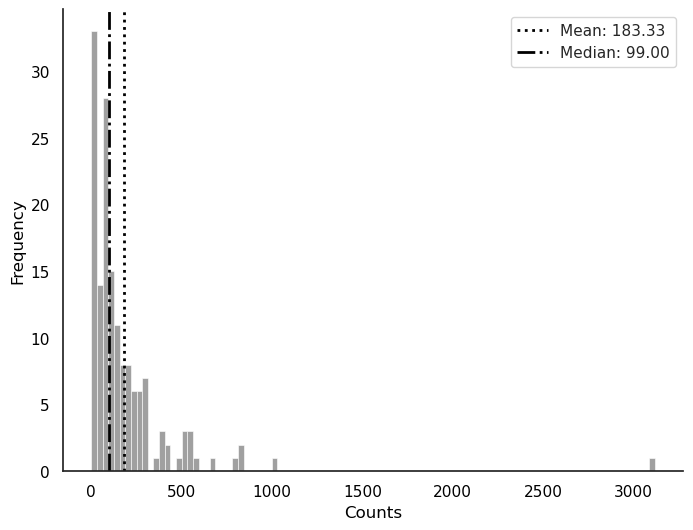

In [26]:
# Set the style for a black and white plot
sns.set(style="white", palette="dark")

# Create the histogram plot
plt.figure(figsize=(8, 6))
sns.histplot(data=labels_dist_df, x='counts', bins=100, color='grey')

# Add vertical lines for mean and median with different styles
plt.axvline(mean_value, color='black', linestyle=':', linewidth=2, label=f'Mean: {mean_value:.2f}') # Dotted line
plt.axvline(median_value, color='black', linestyle='-.', linewidth=2, label=f'Median: {median_value:.2f}') # Dash-dot line

# Add labels and title
plt.xlabel('Counts', color='black')
plt.ylabel('Frequency', color='black')
plt.legend()

# Remove borders
sns.despine()

# Set the ticks color to black
plt.xticks(color='black')
plt.yticks(color='black')

#plt.savefig("label_freq")

# Show the plot
plt.show()

In [27]:
# Statistical summary
labels_dist.describe()

count     156.000000
mean      183.326923
std       297.753290
min         1.000000
25%        48.500000
50%        99.000000
75%       208.000000
max      3119.000000
dtype: float64

In [28]:
# Absent GICS codes
unique_explore_gics = explore_df["GICS"].unique()
codes_not_in_gics = [code for code in set(gics_codes) if code not in unique_explore_gics]
codes_not_in_gics

['40301050', '20305020', '40301030', '60108030', '60108050', '60108020']

# 3 Prepare the data

In [29]:
# Create a copy of data
prepare_df = train_X.copy(deep=True)

# Fill missing values with zeros
prepare_df = prepare_df.fillna(0)

In [30]:
# Data engineering
def data_eng(dataset):
    new_data = pd.DataFrame({

    # Compute common size components
    ## Assets
    "A1" : dataset["che"] / dataset["at"],   # Cash & Marketable Securities
    "A2" : dataset["rect"] / dataset["at"],  # Receivables
    "A3" : dataset["invt"] / dataset["at"],  # Inventories
    "A4" : dataset["act"] / dataset["at"],   # Total current assets
    "A5" : dataset["ppent"] / dataset["at"], # Net Plant & Equipment
    "A6" : dataset["ivaeq"] / dataset["at"], # Investments
    "A7" : dataset["intan"] / dataset["at"], # Goodwill & Intangibles

    ## Liabilities
    "L1" : dataset["ap"] / dataset["at"],   # Accounts Payable
    "L2" : dataset["dlc"] / dataset["at"],  # Total debt in current liabilities
    #"L3" : dataset["ui"] / dataset["at"],  # Unearned income (EXCLUDED)
    "L4" : dataset["lct"] / dataset["at"],  # Total current liabilities
    "L5" : dataset["dltt"] / dataset["at"], # total long-term debt
    "L6" : dataset["lt"] / dataset["at"],   # Total liabilities

    ## Equity
    "E1" : dataset["pstk"] / dataset["at"], # Preferred stock
    "E2" : dataset["ceq"] / dataset["at"],  # Common stock

    ## Ratios
    "R1" : (dataset["sale"] - dataset["cogs"]) / dataset["sale"],                  # Gross Margin
    "R2" : dataset["xrd"] / dataset["sale"],                                       # R&D/Sales
    "R3" : dataset["ib"] / dataset["sale"],                                        # Net Income/Sales
    "R4" : dataset["rect"] * (dataset["sale"] / 365),                              # Days of Receivables
    "R5" : dataset["cogs"] / dataset["invt"],                                      # Inventory Turnover
    "R6" : dataset["sale"] / dataset["ppent"],                                     # Fixed Asset Turnover
    "R7" : dataset["sale"] / dataset["at"],                                        # Total Asset Turnover
    "R8" : dataset["ib"] /  dataset["at"],                                         # Net Income/Assets
    "R9" : dataset["ib"] / dataset["ceq"],                                         # Net Income/Equity
    "R10" : dataset["at"] / dataset["ceq"],                                        # Assets/Equity
    "R11" : (dataset["dlc"] + dataset["dltt"]) / dataset["ceq"],                   # Debt/Equity
    "R12" : dataset["dltt"] / (dataset["pstk"] + dataset["ceq"] + dataset["dltt"]) # L/T Debt/Total Capital
    })

    return new_data

# Run function
new_prepare_df = data_eng(prepare_df)

In [31]:
# % of missing values
prop_na_col2 = round((new_prepare_df.isna().sum() / len(new_prepare_df)) * 100, 2).sort_values(ascending=False)
prop_na2 = round((new_prepare_df.isna().sum().sum() / new_prepare_df.size) * 100, 2)

print(f"Proportion of missing values in each attributes:")
print(prop_na_col2)
print(f"\n{prop_na2}% values are missing in total.")

Proportion of missing values in each attributes:
R12    0.01
A2     0.00
R11    0.00
R10    0.00
R9     0.00
R8     0.00
R7     0.00
R6     0.00
R5     0.00
R4     0.00
R3     0.00
R2     0.00
R1     0.00
A1     0.00
E1     0.00
L6     0.00
L5     0.00
L4     0.00
L2     0.00
L1     0.00
A7     0.00
A6     0.00
A5     0.00
A4     0.00
A3     0.00
E2     0.00
dtype: float64

0.0% values are missing in total.


In [32]:
# % of infinite values

prop_inf_col = round((((new_prepare_df == np.inf) | (new_prepare_df == -np.inf)).sum() / len(new_prepare_df)) * 100, 2).sort_values(ascending=False)
prop_inf = round((((new_prepare_df == np.inf) | (new_prepare_df == -np.inf)).sum().sum() / new_prepare_df.size) * 100, 2)

print(f"Proportion of infinite values in each attribute:")
print(prop_inf_col)
print(f"\n{prop_inf}% values are infinite in total.")

Proportion of infinite values in each attribute:
R6     0.52
R11    0.18
R10    0.18
R9     0.17
A1     0.00
A2     0.00
R8     0.00
R7     0.00
R5     0.00
R4     0.00
R3     0.00
R2     0.00
R1     0.00
E2     0.00
E1     0.00
L6     0.00
L5     0.00
L4     0.00
L2     0.00
L1     0.00
A7     0.00
A6     0.00
A5     0.00
A4     0.00
A3     0.00
R12    0.00
dtype: float64

0.04% values are infinite in total.


In [33]:
# Replace inf values into na
def handle_inf(dataset):
    dataset = dataset.replace([np.inf, -np.inf], np.nan)

    return dataset

new_prepare_df = handle_inf(new_prepare_df.iloc[:, 14:])

In [34]:
def data_scale_impute(dataset):
    # Feature scaling
    scaler = RobustScaler()
    scaled_data = scaler.fit_transform(dataset)

    # Imputation
    imputer = SimpleImputer(strategy="mean")
    imputed_data = imputer.fit_transform(scaled_data)

    return imputed_data

imputed_data = data_scale_impute(new_prepare_df)

In [35]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", RobustScaler())
])

In [36]:
imputed_data_df = pd.DataFrame(imputed_data, columns=new_prepare_df.columns, index=new_prepare_df.index)
imputed_data_df = pd.concat([imputed_data_df, train_y], axis=1)

In [37]:
# Data imbalance

# Function to calculate imbalance ratios
def imbalance_ratio(dataset, label):
    
    # Initialize
    labelPaths = dataset[label]                     # label paths from dataset
    countDict = labelPaths.value_counts().to_dict() # number of samples in dataset labelled with path
    maxCount = max(countDict.values())              # max number of label path in countDict
    IRLbP = {}                                      # empty dict

    # For loop to calculate imbalance ratio per label
    for path in labelPaths:                         
        pathCount = countDict[path]
        IRLbP[path] = round(maxCount/pathCount, 2)
    # For loop ends

    # hierarchical mean imbalance ratio
    HMeanIR = round(sum(IRLbP.values()) / len(IRLbP), 2)

    return IRLbP, HMeanIR

# Function for retrieving minority paths
def min_Paths(dataset, label):

    # Initialize
    IRLbP, HMeanIR = imbalance_ratio(dataset, label) # get imbalce ratio
    minPaths = []                                    # empty list

    # For loop to get minority classes
    for path in dataset[label]:
        if IRLbP[path] > HMeanIR:
            minPaths.append(path)
    # For loop ends

    return minPaths

# Hierarchical random oversampling (full depth)
def HROS_FD(dataset, label, random_state, s=0.1):
    
    # Initialize
    samplesToCreate = int(len(dataset)*s) # number of samples to be created
    minPaths = min_Paths(dataset, label)  # get minority paths
    new_data = dataset.copy()             # copy original dataset
    np.random.seed(random_state)          # for reproducibility

    maxIncrease = samplesToCreate / len(minPaths)   # max number of samples created for each path
    meanSize = dataset[label].value_counts().mean() # the average number of samples of all paths

    # For loop to do oversampling for each minority path
    for labelPath in minPaths:
        numSamples = (dataset[label] == labelPath).sum()
        increased = 0
        # While loop begins
        while increased < maxIncrease and numSamples < meanSize:
            sample_to_duplicate = dataset[dataset[label] == labelPath].sample(n=1, replace=True)
            new_data = pd.concat([new_data, sample_to_duplicate], ignore_index=True)
            numSamples = numSamples + 1
            increased = increased + 1
        # While loop ends
    # For loop ends

    return new_data

In [38]:
# Extract GICS codes and convert them into different levels
def extract_gics(y):
    
    if isinstance(y, pd.DataFrame): # if input is data frame
        result = np.array([series.apply(lambda s: [s[:2], s[:4], s[:6], s]).tolist() for series in y.T.values])
    elif isinstance(y, pd.Series):  # if input is series
        result = np.array(y.apply(lambda s: [s[:2], s[:4], s[:6], s]).tolist())
    else:
        raise TypeError("Input must be a pandas DataFrame or Series")

    return result

In [39]:
# Function to perform feature transformation
def feature_transform(X, y, random_state=42, balance=False, s=0.3):
    
    full_data = pd.concat([X, y], axis=1)                                               # combine X and y
    data1 = data_eng(full_data)                                                         # calculation
    data2 = handle_inf(data1)                                                           # handle infinite values
    data3 = pipeline.fit_transform(data2)                                               # scale and impute

    # Return unbalanced data
    if balance == False:                                                                
        X = data3
        y = extract_gics(y)

    # Return balanced data
    if balance == True:                                                                 
        data3_df = pd.DataFrame(data3, columns=data1.columns, index=data1.index)        # convert feature set into data frame
        data3_df = pd.concat([data3_df, y], axis=1)                                     # combine X and y
        balanced_data = HROS_FD(data3_df, label="GICS", random_state=random_state, s=s) # balance
        X = np.array(balanced_data.iloc[:, :-1])                                        # convert to array
        y = extract_gics(balanced_data.iloc[:, -1])                                     # convert to array

    return X, y

# 4 Shortlist promising models

In [40]:
# Transform training set (unbalanced)
ub_train_X_full, ub_train_y_full = feature_transform(train_X, train_y)

# Random sample 20% data
np.random.seed(42)                                                                    # set seed for reproducibility
ub_num_samples = int(0.2 * len(ub_train_X_full))                                      # number of samples
ub_index = np.random.choice(len(ub_train_X_full), replace=False, size=ub_num_samples) # extract index

ub_train_X = ub_train_X_full[ub_index]
ub_train_y = ub_train_y_full[ub_index]

In [41]:
# Generate balanced training set
balanced_data = HROS_FD(imputed_data_df, label="GICS", random_state=42, s=0.5)

# Transform training set (balanced)
b_train_X_full, b_train_y_full = feature_transform(train_X, train_y, balance=True)

# Random sample 20% data
np.random.seed(42)                                                                 # set seed for reproducibility
b_num_samples = int(0.2 * len(b_train_X_full))                                     # number of samples
b_index = np.random.choice(len(b_train_X_full), replace=False, size=b_num_samples) # extract index

b_train_X = b_train_X_full[b_index]
b_train_y = b_train_y_full[b_index]

In [42]:
# K-fold cross-validation
def cv_f1(x, y, random_state, n_splits, shuffle, model):

    # Separate training set into k folds
    kfold = KFold(random_state=random_state, n_splits=n_splits, shuffle=shuffle)

    # Create an empty list to store values
    h_f1 = []

    # For loop to evaluate performance of each fold
    for train_index, valid_index in kfold.split(x, y):

        X_train, X_valid = x[train_index], x[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]

        model.fit(X_train, y_train)           # train the model
        y_pred = model.predict(X_valid)       # dredict on the test data
        score = round(f1(y_valid, y_pred), 4) # evaluate the model
        h_f1.append(score)                    # append scores
    # For loop ends

    # Convert scores to a numpy array
    h_f1 = np.array(h_f1)

    return h_f1

In [ ]:
# Train models using standard parameters

# Baseline classifiers
tree_clf = DecisionTreeClassifier(random_state=42)
lgb_clf = LGBMClassifier(random_state=42, n_jobs=-1, force_col_wise=True, verbose=-1)
rf_clf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Flat models
flat_tree = FlatClassifier(local_classifier=tree_clf)
flat_lgb = FlatClassifier(local_classifier=lgb_clf)
flat_rf = FlatClassifier(local_classifier=rf_clf)

# LCN models
lcpn_tree = LocalClassifierPerNode(local_classifier=tree_clf)
lcpn_lgb = LocalClassifierPerNode(local_classifier=lgb_clf, n_jobs=-1)
lcpn_rf = LocalClassifierPerNode(local_classifier=rf_clf, n_jobs=-1)

In [ ]:
# LCN-LightGBM-Unbalanced
start_time = time.time()

h_lgb_f1_ub = cv_f1(x=ub_train_X, y=ub_train_y, random_state=42, n_splits=5, model=lcpn_lgb, shuffle=True)

end_time = time.time()
time_used = round(end_time - start_time, 4)
print(f"Time used: {time_used} seconds.")

print("h_lgb_f1_ub: ", h_lgb_f1_ub.mean(), h_lgb_f1_ub.std())

In [ ]:
# LCN-LightGBM-Balanced
start_time = time.time()

h_lgb_f1_b = cv_f1(x=b_train_X, y=b_train_y, random_state=42, n_splits=5, model=lcpn_lgb, shuffle=True)

end_time = time.time()
time_used = round(end_time - start_time, 4)
print(f"Time used: {time_used} seconds.")

print("h_lgb_f1_b: ", h_lgb_f1_b.mean(), h_lgb_f1_b.std())

In [ ]:
# Flat-LightGBM-Unbalanced
start_time = time.time()

flat_lgb_f1_ub = cv_f1(x=ub_train_X, y=ub_train_y, random_state=42, n_splits=5, model=flat_lgb, shuffle=True)

end_time = time.time()
time_used = round(end_time - start_time, 4)
print(f"Time used: {time_used} seconds.")

print("flat_lgb_f1_ub: ", flat_lgb_f1_ub.mean(), flat_lgb_f1_ub.std())

In [ ]:
# Flat-LightGBM-Balanced
start_time = time.time()

flat_lgb_f1_b = cv_f1(x=b_train_X, y=b_train_y, random_state=42, n_splits=5, model=flat_lgb, shuffle=True)

end_time = time.time()
time_used = round(end_time - start_time, 4)
print(f"Time used: {time_used} seconds.")

print("flat_lgb_f1_b: ", flat_lgb_f1_b.mean(), flat_lgb_f1_b.std())

In [ ]:
# LCN-Random Forest-Unbalanced
start_time = time.time()

h_rf_f1_ub = cv_f1(x=ub_train_X, y=ub_train_y, random_state=42, n_splits=5, model=lcpn_rf, shuffle=True)

end_time = time.time()
time_used = round(end_time - start_time, 4)
print(f"Time used: {time_used} seconds.")

print("h_rf_f1_ub: ", h_rf_f1_ub.mean(), h_rf_f1_ub.std())

In [ ]:
# LCN-Random Forest-Balanced
start_time = time.time()

h_rf_f1_b = cv_f1(x=b_train_X, y=b_train_y, random_state=42, n_splits=5, model=lcpn_rf, shuffle=True)

end_time = time.time()
time_used = round(end_time - start_time, 4)
print(f"Time used: {time_used} seconds.")

print("h_rf_f1_b: ", h_rf_f1_b.mean(), h_rf_f1_b.std())

In [ ]:
# Flat-Random Forest-Unbalanced
start_time = time.time()

flat_rf_f1_ub = cv_f1(x=ub_train_X, y=ub_train_y, random_state=42, n_splits=5, model=flat_rf, shuffle=True)

end_time = time.time()
time_used = round(end_time - start_time, 4)
print(f"Time used: {time_used} seconds.")

print("flat_rf_f1_ub: ", flat_rf_f1_ub.mean(), flat_rf_f1_ub.std())

In [ ]:
# Flat-Random Forest-Balanced
start_time = time.time()

flat_rf_f1_b = cv_f1(x=b_train_X, y=b_train_y, random_state=42, n_splits=5, model=flat_rf, shuffle=True)

end_time = time.time()
time_used = round(end_time - start_time, 4)
print(f"Time used: {time_used} seconds.")

print("flat_rf_f1_b: ", flat_rf_f1_b.mean(), flat_rf_f1_b.std())

In [ ]:
# Flat-Decision Tree-Unbalanced
start_time = time.time()

flat_tree_f1_ub = cv_f1(x=ub_train_X, y=ub_train_y, random_state=42, n_splits=5, model=flat_tree, shuffle=True)

end_time = time.time()
time_used = round(end_time - start_time, 4)
print(f"Time used: {time_used} seconds.")

print("flat_tree_f1_ub: ", flat_tree_f1_ub.mean(), flat_tree_f1_ub.std())

In [ ]:
# Flat-Decision Tree-Balanced
start_time = time.time()

flat_tree_f1_b = cv_f1(x=b_train_X, y=b_train_y, random_state=42, n_splits=5, model=flat_tree, shuffle=True)

end_time = time.time()
time_used = round(end_time - start_time, 4)
print(f"Time used: {time_used} seconds.")

print("flat_tree_f1_b: ", flat_tree_f1_b.mean(), flat_tree_f1_b.std())

In [ ]:
# LCN-Decision Tree-Unbalanced
start_time = time.time()

h_tree_f1_ub = cv_f1(x=ub_train_X, y=ub_train_y, random_state=42, n_splits=5, model=lcpn_tree, shuffle=True)

end_time = time.time()
time_used = round(end_time - start_time, 4)
print(f"Time used: {time_used} seconds.")

print("h_tree_f1_ub: ", h_tree_f1_ub.mean(), h_tree_f1_ub.std())

In [ ]:
# LCN-Decision Tree-Balanced
start_time = time.time()

h_tree_f1_b = cv_f1(x=b_train_X, y=b_train_y, random_state=42, n_splits=5, model=lcpn_tree, shuffle=True)

end_time = time.time()
time_used = round(end_time - start_time, 4)
print(f"Time used: {time_used} seconds.")

print("h_tree_f1_b: ", h_tree_f1_b.mean(), h_tree_f1_b.std())

In [ ]:
# Print results
print("flat_ub")
print("flat_tree_f1_ub: ", round(flat_tree_f1_ub.mean(), 4), round(flat_tree_f1_ub.std(), 4))
print("flat_lgb_f1_ub: ", round(flat_lgb_f1_ub.mean(), 4), round(flat_lgb_f1_ub.std(), 4))
print("flat_rf_f1_ub: ", round(flat_rf_f1_ub.mean(), 4), round(flat_rf_f1_ub.std(), 4))
print("h_ub")
print("h_tree_f1_ub: ", round(h_tree_f1_ub.mean(), 4), round(h_tree_f1_ub.std(), 4))
print("h_lgb_f1_ub: ", round(h_lgb_f1_ub.mean(), 4), round(h_lgb_f1_ub.std(), 4))
print("h_rf_f1_ub: ", round(h_rf_f1_ub.mean(), 4), round(h_rf_f1_ub.std(), 4))
print("flat_b")
print("flat_tree_f1_b: ", round(flat_tree_f1_b.mean(), 4), round(flat_tree_f1_b.std(), 4))
print("flat_lgb_f1_b: ", round(flat_lgb_f1_b.mean(), 4), round(flat_lgb_f1_b.std(), 4))
print("flat_rf_f1_b: ", round(flat_rf_f1_b.mean(), 4), round(flat_rf_f1_b.std(), 4))
print("h_b")
print("h_tree_f1_b: ", round(h_tree_f1_b.mean(), 4), round(h_tree_f1_b.std(),4))
print("h_lgb_f1_b: ", round(h_lgb_f1_b.mean(), 4), round(h_lgb_f1_b.std(), 4))
print("h_rf_f1_b: ", round(h_rf_f1_b.mean(), 4), round(h_rf_f1_b.std(), 4))

# 5 Fine-tune the system

In [44]:
# Transform test set
t_test_X, t_test_y = feature_transform(test_X, test_y)

### Confusion Matrix

In [45]:
# Add root to the predictions
def add_root(array):
    # Create a new column with 'root'
    root = np.full((array.shape[0], 1), 'root')

    # Concatenate the new column to the original array
    new_array = np.hstack((root, array))

    return new_array

# Clean unnecessary separators
def clean_edges(array):
    
    def extract_last_part(s):
        return s.split("::")[-1] if "::" in s else s
    
    for row in array:
        row[0] = extract_last_part(row[0])
        row[1] = extract_last_part(row[1])
        
    return array

# Extract hierarchy from LCN model
def extract_hierarchy(model):
    
    hierarchy = model.hierarchy_
    edges = np.array(hierarchy.edges)
    cleaned_edges = clean_edges(edges)
    
    graph = nx.DiGraph()
    graph.add_edges_from(cleaned_edges)

    return graph

# Calcualte evalution metrics
def eva_metrics(confusion_m, metrics):
    
    TP = confusion_m[0]
    TN = confusion_m[1]
    FP = confusion_m[2]
    FN = confusion_m[3]

    tpfp = np.float64(TP + FP)
    tpfn = np.float64(TP + FN)
    tnfp = np.float64(TN + FP)
    tnfn = np.float64(TN + FN)

    F1 = 2 * TP / (2 * TP + FP + FN)
    PPV = TP / (TP + FP)
    REC = TP / (TP + FN)
    ACC = (TP + TN) / (TP + TN + FP + FN)
    MCC = ((TP * TN) - (FP * FN)) / np.sqrt(float(tpfp*tpfn*tnfp*tnfn))

    if metrics == "f1":
        return F1
    elif metrics == "ppv":
        return PPV
    elif metrics == "rec":
        return REC
    elif metrics == "acc":
        return ACC
    elif metrics == "mcc":
        return mcc
    else: 
        return F1, PPV, REC, ACC, MCC

# Function to return confusion matrix
def h_confusion_matrix(model, metrics, depth=4):
    
    pred_y = model.predict(t_test_X)
    full_pred_y = add_root(pred_y)

    graph = extract_hierarchy(model)
    
    evalLabel_data = {}
    for i in range(len(test_y)):
        evalLabel_data[i] = {"true": [t_test_y[:, depth-1][i]],
                             "pred": [full_pred_y[i].tolist()]}

    h_confusion = {}
    h_confusion_total = []
    for key in evalLabel_data:
        try:
            h_confusion[key] = determineHierarchicalConfusionMatrix(graph, evalLabel_data[key]["true"], evalLabel_data[key]["pred"])
            h_confusion_total.append(h_confusion[key])
        except KeyError as e:
            print(f"Skipping key {key} due to missing data: {e}")
            print(evalLabel_data[key])
        except Exception as e:
            print(f"Skipping key {key} due to an error: {e}")
            print(evalLabel_data[key])
    h_confusion_total = np.sum(np.asarray(h_confusion_total),axis=0)

    if metrics == "all":
        F1, PPV, REC, ACC, MCC = eva_metrics(h_confusion_total, "all")

        print("{:<10} {:<10} {:<10} {:<10} {:<10} {:<10} {:<10} {:<10} {:<10}".format(
        "F1", "PPV", "REC", "ACC", "MCC", "TP", "TN", "FP", "FN"))
        print("{:<10.4f} {:<10.4f} {:<10.4f} {:<10.4f} {:<10.4f} {:<10} {:<10} {:<10} {:<10}".format(
        F1, PPV, REC, ACC, MCC, h_confusion_total[0], h_confusion_total[1], h_confusion_total[2], h_confusion_total[3]))
    else:
        return eva_metrics(h_confusion_total, metrics)

### LCN-LightGBM

In [46]:
# Automatic hyperparameter tuning-LCN-LightGBM
def objective_lgb(trial):

    param = {
        "lambda_l1" : trial.suggest_float("lambda_l1", 0.01, 10.0, log=True),
        "lambda_l2" : trial.suggest_float("lambda_l2", 0.01, 10.0, log=True),
        "num_leaves" : trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction" : trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction" : trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq" : trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples" : trial.suggest_int("min_child_samples", 5, 100),
        "min_data_in_leaf" : trial.suggest_int("min_data_in_leaf", 5, 100)
    }
    
    lgb = LGBMClassifier(**param, random_state=24, n_jobs=-1, force_col_wise=True, verbose=-1)

    lcpn_lgb = LocalClassifierPerNode(local_classifier=lgb, n_jobs=-1)

    score = cv_f1(x=b_train_X, y=b_train_y, random_state=24, n_splits=5, model=lcpn_lgb, shuffle=True).mean()

    return score

In [ ]:
# Create a study
study_lgb = optuna.create_study(direction="maximize", 
                                sampler=optuna.samplers.TPESampler(42), 
                                pruner=optuna.pruners.MedianPruner(n_startup_trials=5, 
                                                                   n_warmup_steps=30,
                                                                   interval_steps=10, 
                                                                   n_min_trials=50))
# Perform tuning
study_lgb.optimize(objective_lgb, n_trials=100)

In [47]:
#best_param_lgb = study_lgb.best_params
#print(best_param_lgb)

best_lgb = LGBMClassifier(**{'lambda_l1': 0.029591135484459515, 
                             'lambda_l2': 0.018957124806160918, 
                             'num_leaves': 124, 
                             'feature_fraction': 0.7614565681709736, 
                             'bagging_fraction': 0.9473661138179675, 
                             'bagging_freq': 4, 
                             'min_child_samples': 14, 
                             'min_data_in_leaf': 11},
                         random_state=24, 
                         n_jobs=-1, 
                         force_col_wise=True, 
                         verbose=-1)

best_lcpn_lgb = LocalClassifierPerNode(local_classifier=best_lgb, n_jobs=-1)

best_lcpn_lgb.fit(b_train_X_full, b_train_y_full)
best_lcpn_lgb_pred = best_lcpn_lgb.predict(t_test_X)
best_lcpn_lgb_f1 = f1(t_test_y, best_lcpn_lgb_pred)

print("The final F1 value for lgb is: ", round(best_lcpn_lgb_f1, 4))

The final F1 value for lgb is:  0.7419


{'lambda_l1': 0.029591135484459515, 'lambda_l2': 0.018957124806160918, 'num_leaves': 124, 'feature_fraction': 0.7614565681709736, 'bagging_fraction': 0.9473661138179675, 'bagging_freq': 4, 'min_child_samples': 14, 'min_data_in_leaf': 11}

In [ ]:
# 5-fold cross validation
cv_f1(x=b_train_X_full, y=b_train_y_full, random_state=42, n_splits=5, model=best_lcpn_lgb, shuffle=True).mean()

In [ ]:
# Hierarchical confusion matrix
h_confusion_matrix(best_lcpn_lgb, "all")

### Flat-Random Forest

In [ ]:
# Automatic hyperparameter tuning-Flat-Random Forest
def objective_frf(trial):

    param = {
        "n_estimators": trial.suggest_int("n_estimators", 10, 200, log=True),
        "max_depth": trial.suggest_int("max_depth", 2, 50),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 100),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 100)
    }
    
    rf = RandomForestClassifier(**param, random_state=24, n_jobs=-1)

    flat_rf = FlatClassifier(local_classifier=rf)

    score = cv_f1(x=b_train_X, y=b_train_y, random_state=24, n_splits=5, model=flat_rf, shuffle=True).mean()

    return score

In [ ]:
# Create a study
study_frf = optuna.create_study(direction="maximize", 
                                sampler=optuna.samplers.TPESampler(42))

# Perform tuning
study_frf.optimize(objective_frf, n_trials=100)

In [ ]:
#best_param_frf = study_frf.best_params
#print(best_param_frf)

best_frf = RandomForestClassifier(**{'n_estimators': 123, 
                                     'max_depth': 43, 
                                     'min_samples_split': 2, 
                                     'min_samples_leaf': 1},
                                  random_state=24, 
                                  n_jobs=-1)

best_flat_rf = FlatClassifier(local_classifier=best_frf)

best_flat_rf.fit(b_train_X_full, b_train_y_full)
best_flat_rf_pred = best_flat_rf.predict(t_test_X)
best_flat_rf_f1 = f1(t_test_y, best_flat_rf_pred)

print("The final F1 value for flat rf is: ", round(best_flat_rf_f1, 4))

{'n_estimators': 123, 'max_depth': 43, 'min_samples_split': 2, 'min_samples_leaf': 1}

In [ ]:
# 5-fold cross validation
cv_f1(x=b_train_X_full, y=b_train_y_full, random_state=42, n_splits=5, model=best_flat_rf, shuffle=True).mean()

In [ ]:
# Evaluations for Flat-Random Forest
frf_f1 = f1_score(t_test_y[:, -1].tolist(), best_flat_rf_pred[:, -1].tolist(), average="macro")
frf_ppv = precision_score(t_test_y[:, -1].tolist(), best_flat_rf_pred[:, -1].tolist(), average="macro")
frf_rec = recall_score(t_test_y[:, -1].tolist(), best_flat_rf_pred[:, -1].tolist(), average="macro")
frf_acc = accuracy_score(t_test_y[:, -1].tolist(), best_flat_rf_pred[:, -1].tolist())

print("{:<10} {:<10} {:<10} {:<10}".format(
        "F1", "PPV", "REC", "ACC"))
print("{:<10.4f} {:<10.4f} {:<10.4f} {:<10.4f}".format(
        frf_f1, frf_ppv, frf_rec, frf_acc))

# Further analysis
Evaluation of LCN-LightGBM at different levels

In [48]:
# Extract different GICS levels

# Training sets
b_train_y3 = b_train_y_full[:, 0:3] # 3 levels (6 digits)
b_train_y2 = b_train_y_full[:, 0:2] # 2 levels (4 digits)
b_train_y1 = b_train_y_full[:, 0:1] # 1 level (2 digits)

# Test sets
t_test_y3 = t_test_y[:, 0:3] # 3 levels (6 digits)
t_test_y2 = t_test_y[:, 0:2] # 2 levels (4 digits)
t_test_y1 = t_test_y[:, 0:1] # 1 level (2 digits)

In [49]:
# 4 levels
best_lcpn_lgb_l4 = best_lcpn_lgb.fit(b_train_X_full, b_train_y_full)
h_confusion_matrix(best_lcpn_lgb_l4, "all")

F1         PPV        REC        ACC        MCC        TP         TN         FP         FN        
0.7419     0.7419     0.7419     0.8911     0.6729     36375      170783     12653      12653     


In [51]:
# 3 levels
best_lcpn_lgb_l3 = best_lcpn_lgb.fit(b_train_X_full, b_train_y3)
h_confusion_matrix(best_lcpn_lgb_l3, "all", depth=3)

F1         PPV        REC        ACC        MCC        TP         TN         FP         FN        
0.7624     0.7624     0.7624     0.9130     0.7092     28036      155400     8735       8735      


In [52]:
# 2 level
best_lcpn_lgb_l2 = best_lcpn_lgb.fit(b_train_X_full, b_train_y2)
h_confusion_matrix(best_lcpn_lgb_l2, "all", depth=2)

F1         PPV        REC        ACC        MCC        TP         TN         FP         FN        
0.7881     0.7881     0.7881     0.9369     0.7510     19320      134877     5194       5194      


In [53]:
# Adjust confusion matrix function for 1-level GICS

# Add root to the predictions
def add_root2(array):
    # Convert the 1D array to a 2D array
    if array.ndim == 1:
        array = array[:, np.newaxis]
    
    root = np.full((array.shape[0], 1), 'root', dtype=object)
    
    # Concatenate the new column to the original array
    new_array = np.hstack((root, array))
    
    return new_array

# Function to generate confusion matrix for 1 level GICS
def h_confusion_matrix2(model, metrics, depth=4):
    
    pred_y = model.predict(t_test_X)
    full_pred_y = add_root2(pred_y)

    graph = extract_hierarchy(model)
    
    evalLabel_data = {}
    for i in range(len(test_y)):
        evalLabel_data[i] = {"true": [t_test_y[:, depth-1][i]],
                             "pred": [full_pred_y[i].tolist()]}

    h_confusion = {}
    h_confusion_total = []
    for key in evalLabel_data:
        try:
            h_confusion[key] = determineHierarchicalConfusionMatrix(graph, evalLabel_data[key]["true"], evalLabel_data[key]["pred"])
            h_confusion_total.append(h_confusion[key])
        except KeyError as e:
            print(f"Skipping key {key} due to missing data: {e}")
            print(evalLabel_data[key])
        except Exception as e:
            print(f"Skipping key {key} due to an error: {e}")
            print(evalLabel_data[key])
    h_confusion_total = np.sum(np.asarray(h_confusion_total),axis=0)

    if metrics == "all":
        F1, PPV, REC, ACC, MCC = eva_metrics(h_confusion_total, "all")

        print("{:<10} {:<10} {:<10} {:<10} {:<10} {:<10} {:<10} {:<10} {:<10}".format(
        "F1", "PPV", "REC", "ACC", "MCC", "TP", "TN", "FP", "FN"))
        print("{:<10.4f} {:<10.4f} {:<10.4f} {:<10.4f} {:<10.4f} {:<10} {:<10} {:<10} {:<10}".format(
        F1, PPV, REC, ACC, MCC, h_confusion_total[0], h_confusion_total[1], h_confusion_total[2], h_confusion_total[3]))
    else:
        return eva_metrics(h_confusion_total, metrics)

In [54]:
# 1 level
best_lcpn_lgb_l1 = best_lcpn_lgb.fit(b_train_X_full, b_train_y1)
h_confusion_matrix2(best_lcpn_lgb_l1, "all", depth=1)

F1         PPV        REC        ACC        MCC        TP         TN         FP         FN        
0.8109     0.8109     0.8109     0.9656     0.7920     9939       120252     2318       2318      
